In [1]:

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [3]:

#datos = pd.read_csv('vendes4.csv', delimiter=";",decimal=",", parse_dates=[0], header=None,index_col=0, squeeze=True)
datos = pd.read_csv('vendes3.csv', delimiter=";",decimal=",")
#,names=['dia','vendes'])

# Preparación del dato
# ==============================================================================

datos['dia'] = pd.to_datetime(datos['dia'], format='%d/%m/%Y')
scaler = MinMaxScaler(feature_range=(-1, 1))
#values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
datos_venda = datos[["venda"]]

datos["venda"] = scaler.fit_transform(datos_venda)

datos = datos.set_index('dia')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()


,venda
dia,
2015-10-01,-0.548975
2015-11-01,-1.000000
2015-12-01,-0.501779
2016-01-01,-1.000000
2016-02-01,-0.512332


In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [5]:
datos.asfreq(freq='D', fill_value=np.nan)

,venda
dia,
2015-10-01,-0.548975
2015-10-02,NaN
2015-10-03,NaN
2015-10-04,NaN
2015-10-05,NaN
...,...
2021-09-27,NaN
2021-09-28,NaN
2021-09-29,NaN


               venda
dia                 
2015-10-01 -0.548975
2015-11-01 -1.000000
2015-12-01 -0.501779
2016-01-01 -1.000000
2016-02-01 -0.512332
...              ...
2020-06-01 -0.399182
2020-07-01 -0.422150
2020-08-01 -1.000000
2020-09-01 -0.464324
2020-10-01 -0.422882

[61 rows x 1 columns]
               venda
dia                 
2020-11-01 -1.000000
2020-12-01 -0.468497
2021-01-01 -1.000000
2021-02-01 -0.423469
2021-03-01 -0.473286
2021-04-01 -0.145620
2021-05-01 -1.000000
2021-06-01 -0.446871
2021-07-01 -0.434538
2021-08-01 -1.000000
2021-09-01 -0.469682
2021-10-01 -0.442208


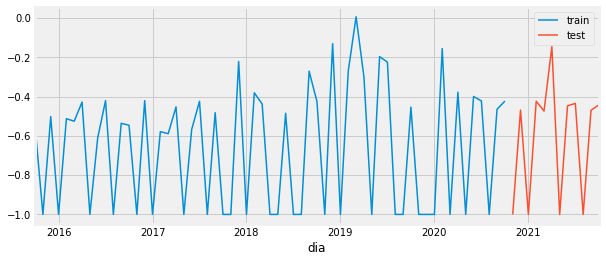

In [6]:
# Separación datos train-test
# ==============================================================================
steps = 12
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(datos_train)
print(datos_test)
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['venda'].plot(ax=ax, label='train')
datos_test['venda'].plot(ax=ax, label='test')
ax.legend();


In [7]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['venda'])
forecaster



ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-10-01 00:00:00'), Timestamp('2020-10-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-15 22:33:08 
Last fit date: 2021-12-15 22:33:09 
Skforecast version: 0.4.0 

In [8]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(12)

2020-11-01   -0.985377
2020-12-01   -0.650850
2021-01-01   -0.459709
2021-02-01   -0.940562
2021-03-01   -0.548552
2021-04-01   -0.626709
2021-05-01   -0.588536
2021-06-01   -0.498683
2021-07-01   -0.794608
2021-08-01   -0.612060
2021-09-01   -0.476201
2021-10-01   -0.836199
Freq: MS, Name: pred, dtype: float64

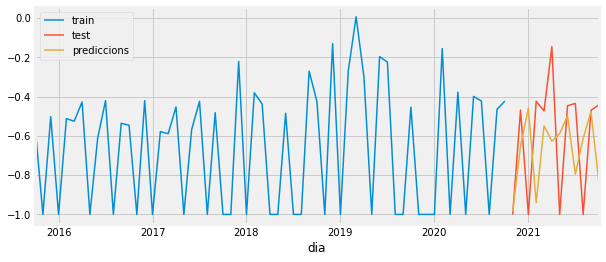

In [9]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['venda'].plot(ax=ax, label='train')
datos_test['venda'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='prediccions')
ax.legend();

In [10]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['venda'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.1197736906718384


In [11]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [5, 10]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['venda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 12,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:53<00:00, 26.68s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 10, 'n_estimators': 100}



In [12]:
# Resultados Grid Search
# ==============================================================================
resultados_grid


,lags,params,metric,max_depth,n_estimators
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.175896,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.176897,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.180840,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.190258,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.191630,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.192741,5,500
1,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 500}",0.219421,3,500
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",0.221910,3,100
5,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",0.223677,10,500
2,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",0.225969,5,100


In [13]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )
forecaster.fit(y=datos_train['venda'])

In [14]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

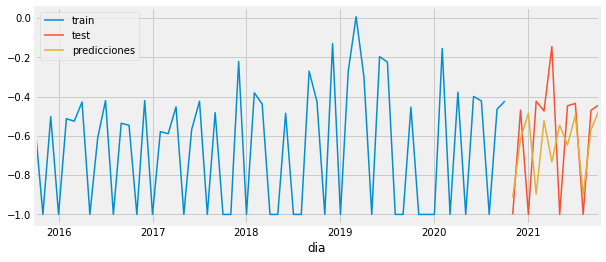

In [15]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['venda'].plot(ax=ax, label='train')
datos_test['venda'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [16]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['venda'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.09449137867304175


<AxesSubplot:>

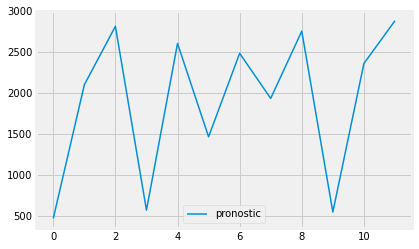

In [17]:

predicciones1=predicciones.values.reshape(-1,1)

inverted = scaler.inverse_transform(predicciones1)
inverted

prediccion1 = pd.DataFrame(inverted)
prediccion1.columns = ['pronostic']
prediccion1.plot()
